In [31]:
import seaborn as sns

custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 1.25,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif"}
sns.set_theme(context = "poster", style="ticks", rc=custom_params) 

x function to load data from a csv all_runs.csv
x function to dedrift x from shear
- function to compute displacements
- function to plot pdf of displacements
- function to compute msds from displacements, optionally plot them, and extract D, returns a warning if exponent is not 1 pm 5%

- loop to go through sweep_runs and find all all_runs.csv, plotting D against phi


In [32]:
import re

def extract_volume_fraction_phi(name) :
    """
    Takes directory name, extracts first numerical value (phi).
    Returns phi. If not found, returns None.

    """
    match = re.search(r'phi=([0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)', name)
    if match:
        pair_number = match.group(1)
        try:
            return float(pair_number)
        except ValueError:
            print(f"Error.")
    return None

In [33]:
def correction_shear(df, shear_rate, timestep_duration, original_x_col='x_original'):
    """
    Incrementally remove linear shear flow in x due to shear_rate * z * dt.
    Overwrite df['x'] with corrected values each time, referencing an 'x_original' column to avoid double correction.

    """

    df = df.copy()

    if original_x_col not in df.columns:
        df[original_x_col] = df['x']

    df['dx_shear'] = shear_rate * df['z'] * timestep_duration
    df['dx'] = df.groupby(['run', 'particle_id'])[original_x_col].diff().fillna(0)

    df['dx_corrected'] = df['dx'] - df['dx_shear']
    df['x'] = df.groupby(['run', 'particle_id'])['dx_corrected'].cumsum()


    initial_x = df.groupby(['run', 'particle_id'])[original_x_col].transform('first')
    df['x'] += initial_x

    df.drop(columns=['dx_shear', 'dx', 'dx_corrected'], inplace=True)

    return df

In [34]:
import numpy as np
import pandas as pd

def compute_msds(df):
    """
    Compute ensemble-averaged MSDs (x, y, z) and total MSD,
    with standard deviations, across multiple simulation runs for stats.
    
    Parameters:
        df (pd.DataFrame): Columns: ['run', 'timestep', 'particle_id', 'x', 'y', 'z']
    
    Returns:
        lags (np.ndarray)
        msd_dict (dict): keys = 'x', 'y', 'z', 'total', each maps to (mean, std)
    """
    df = df.sort_values(by=['run', 'particle_id', 'timestep'])

    msd_x, msd_y, msd_z, msd_total = [], [], [], []

    grouped = df.groupby(['run', 'particle_id'])

    for (run, pid), group in grouped:
        x, y, z = group['x'].values, group['y'].values, group['z'].values
        n = len(x)
        max_lag = n // 2

        if max_lag < 1:
            print(f"Skipping run {run}, particle {pid} — too few timesteps ({n})")
            continue

        def compute_msd_1d(arr):
            try:
                msd = np.array([
                    np.mean((arr[lag:] - arr[:-lag]) ** 2)
                    for lag in range(1, max_lag + 1)
                ])
                #NaN Inf
                if np.any(np.isnan(msd)) or np.any(np.isinf(msd)):
                    raise ValueError("Invalid MSD values")
                return msd
            except Exception as e:
                print(f"Failed to compute MSD for run {run}, particle {pid}: {e}")
                return None

        x_msd = compute_msd_1d(x)
        y_msd = compute_msd_1d(y)
        z_msd = compute_msd_1d(z)

        if x_msd is None or y_msd is None or z_msd is None:
            continue  # Skip 

        msd_x.append(x_msd)
        msd_y.append(y_msd)
        msd_z.append(z_msd)
        msd_total.append(x_msd + y_msd + z_msd)

    if not msd_x:
        raise ValueError("No valid trajectories for MSD calculation.")

    msd_x = np.vstack(msd_x)
    msd_y = np.vstack(msd_y)
    msd_z = np.vstack(msd_z)
    msd_total = np.vstack(msd_total)

    lags = np.arange(1, msd_x.shape[1] + 1)

    msd_dict = {
        'x': (msd_x.mean(axis=0), msd_x.std(axis=0)),
        'y': (msd_y.mean(axis=0), msd_y.std(axis=0)),
        'z': (msd_z.mean(axis=0), msd_z.std(axis=0)),
        'total': (msd_total.mean(axis=0), msd_total.std(axis=0)),
    }

    return lags, msd_dict



Testing over Einstein problem

In [35]:
import scipy
from pathlib import Path
import matplotlib.pyplot as plt


def processing_all_csv(results_root, timestep_duration, shear_rate, plot_msd = True):
    csv_paths = sorted(results_root.glob("*/all_runs.csv"))
    phi_list = []
    D_data = {'total': [], 
              'x': [], 
              'y': [], 
              'z': []}

    for csv_path in csv_paths:
        try:
            df = pd.read_csv(csv_path)
            lags, msd = compute_msds(df)
        except Exception as e:
            print(f"Failed for {csv_path}: {e}")
        folder_name = csv_path.parent.name
        
        try:
            phi = extract_volume_fraction_phi(folder_name)
        except ValueError:
            print(f"Could not extract phi from folder name: {folder_name}")
            continue

        print(f"Processing {csv_path} (phi={phi})")
        df = correction_shear(df, shear_rate=shear_rate, timestep_duration=timestep_duration) 
        lags, msd = compute_msds(df)


        # Plot MSDs per axis on one plot and total on a second plot

        fig, axs = plt.subplots(2,1)

        axs[0].plot(lags * timestep_duration, msd['x'][0] / (lags * timestep_duration))
        axs[0].plot(lags * timestep_duration, msd['y'][0] / (lags * timestep_duration))
        axs[0].plot(lags * timestep_duration, msd['z'][0] / (lags * timestep_duration))


        # axs[0].fill_between(lags * timestep_duration, msd['x'][0] - msd['x'][1], msd['x'][0] + msd['x'][1], alpha = 0.3)
        # axs[0].fill_between(lags * timestep_duration, msd['y'][0] - msd['y'][1], msd['y'][0] + msd['y'][1], alpha = 0.3)
        # axs[0].fill_between(lags * timestep_duration, msd['z'][0] - msd['z'][1], msd['z'][0] + msd['z'][1], alpha = 0.3)

        axs[0].set_xlabel('$t$ (s)')
        axs[0].set_ylabel('MSD (um2/s)')


        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

        axs[1].plot(lags * timestep_duration, msd['total'][0] / (lags * timestep_duration))
        # axs[1].fill_between(lags * timestep_duration, msd['total'][0] - msd['total'][1], msd['total'][0] + msd['total'][1])

        axs[0].set_xlabel('$t$ (s)')
        axs[0].set_ylabel('MSD (um2/s)')

        axs[1].set_xscale('log')
        axs[1].set_yscale('log')
        
        plt.show()

        time_cutoff = 1e-2
        D_results = {}

        for axis in ['total', 'x', 'y', 'z']:
            valid = (lags >= time_cutoff)

            if np.sum(valid) < 2:
                slope, intercept, D_fit = np.nan, np.nan, np.nan
            else:
                log_lags = np.log(lags[valid])
                log_msd = np.log(msd[axis][0][valid])  # mean MSD

                slope, intercept, *_ = scipy.stats.linregress(log_lags, log_msd)
                D_fit = np.exp(intercept) / 2

            D_results[axis] = D_fit

        # Store results
        phi_list.append(phi)
        for axis in ['total', 'x', 'y', 'z']:
            D_data[axis].append(D_results[axis])

    # Plotting
    phi_array = np.array(phi_list)
    plt.figure()
    for axis in ['x', 'y', 'z']:
        plt.plot(phi_array, D_data[axis], 'o', label=f"$D_{axis}$")

    plt.xlabel("$\Phi$")
    plt.ylabel("D [$\mu m^2/s$]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




results_root = Path("/Users/juls/RigidMultiblobsWall-1/multi_bodies/examples/alex_problem/sweep_runs/")
timestep_duration = 1e-3
shear_rate = 0.


<>:92: SyntaxWarning: invalid escape sequence '\P'
<>:93: SyntaxWarning: invalid escape sequence '\m'
<>:92: SyntaxWarning: invalid escape sequence '\P'
<>:93: SyntaxWarning: invalid escape sequence '\m'
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_4119/3754444331.py:92: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel("$\Phi$")
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_4119/3754444331.py:93: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("D [$\mu m^2/s$]")


Processing /Users/juls/RigidMultiblobsWall-1/multi_bodies/examples/alex_problem/sweep_runs/phi=0.0001625/all_runs.csv (phi=0.0001625)


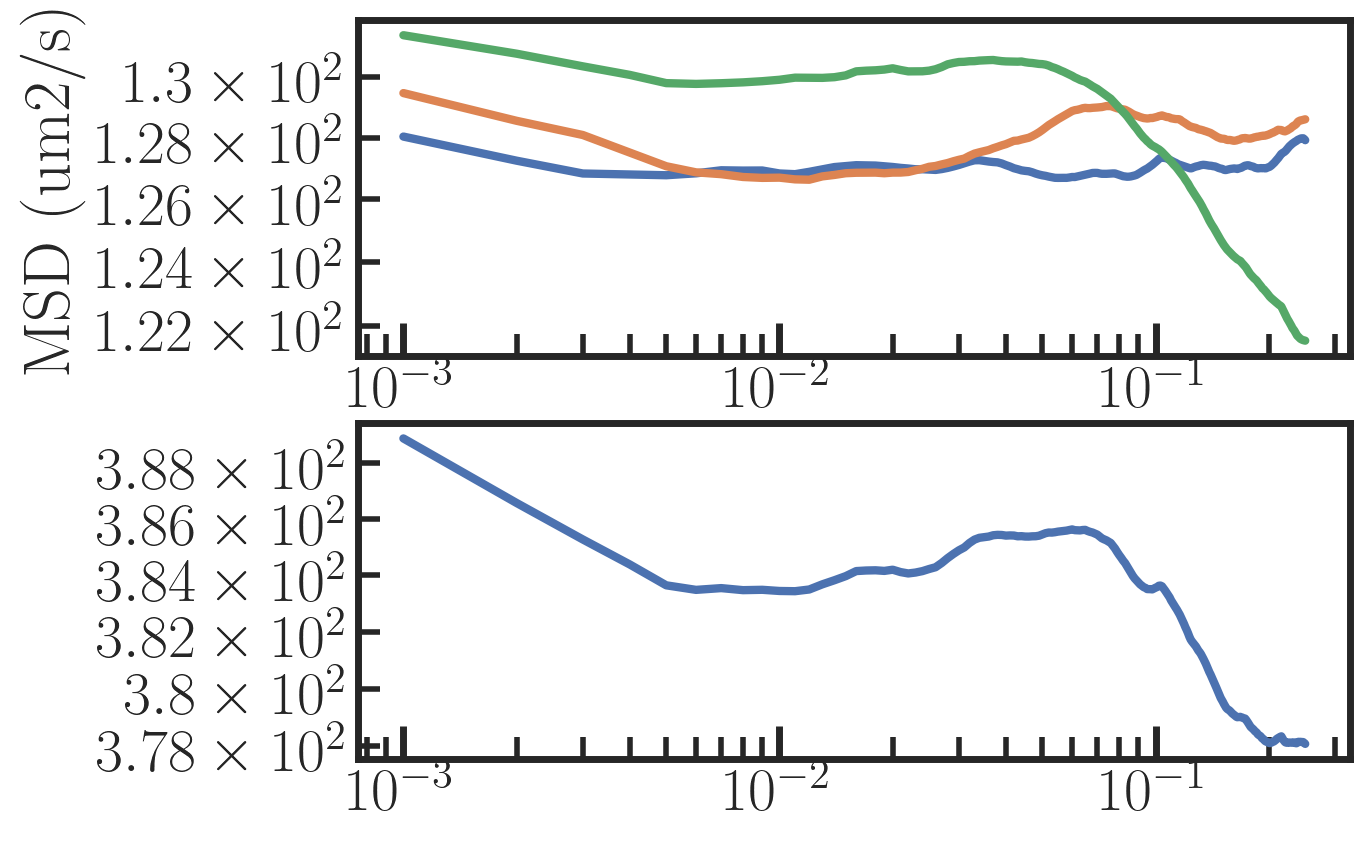

Processing /Users/juls/RigidMultiblobsWall-1/multi_bodies/examples/alex_problem/sweep_runs/phi=0.000275/all_runs.csv (phi=0.000275)


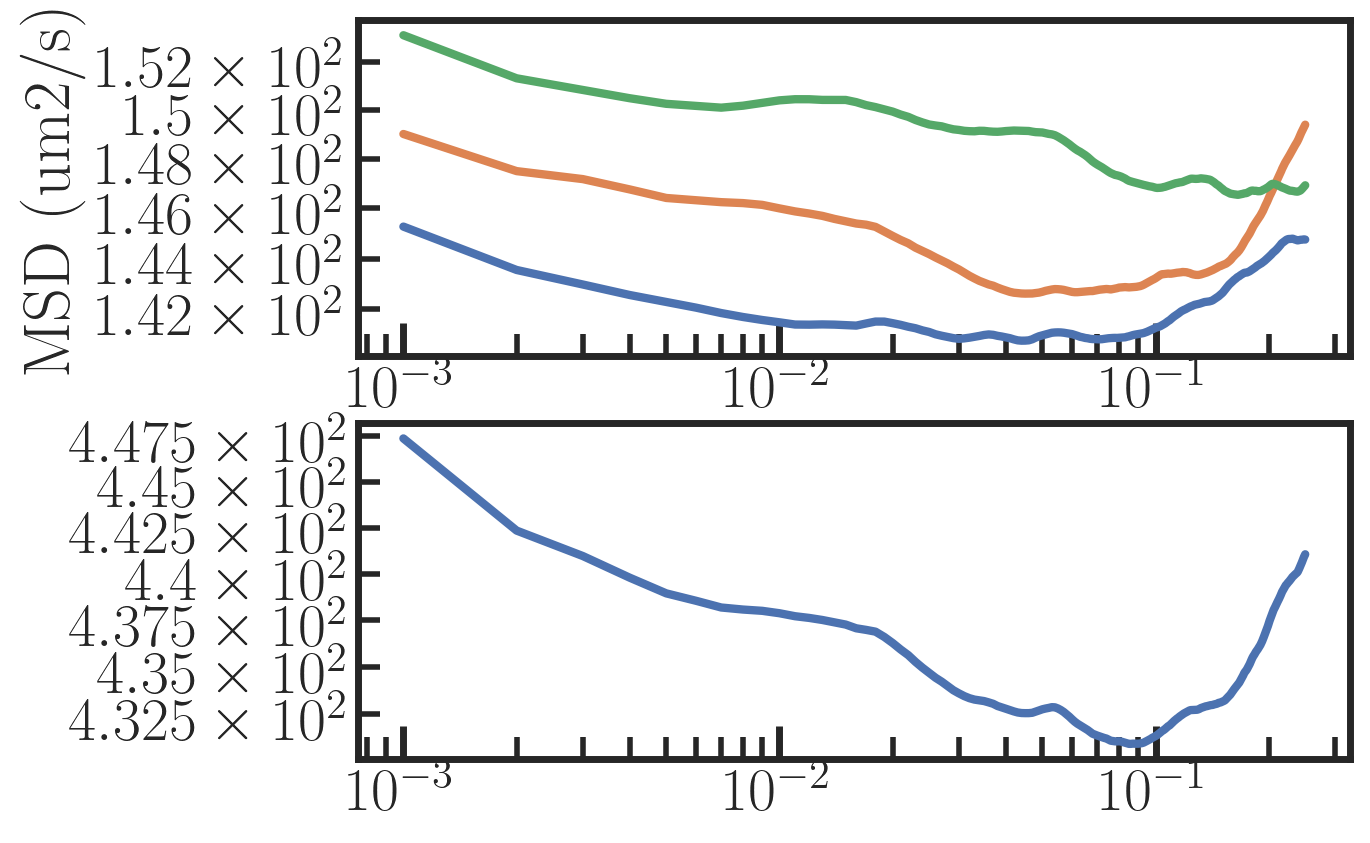

Processing /Users/juls/RigidMultiblobsWall-1/multi_bodies/examples/alex_problem/sweep_runs/phi=0.0003875/all_runs.csv (phi=0.0003875)


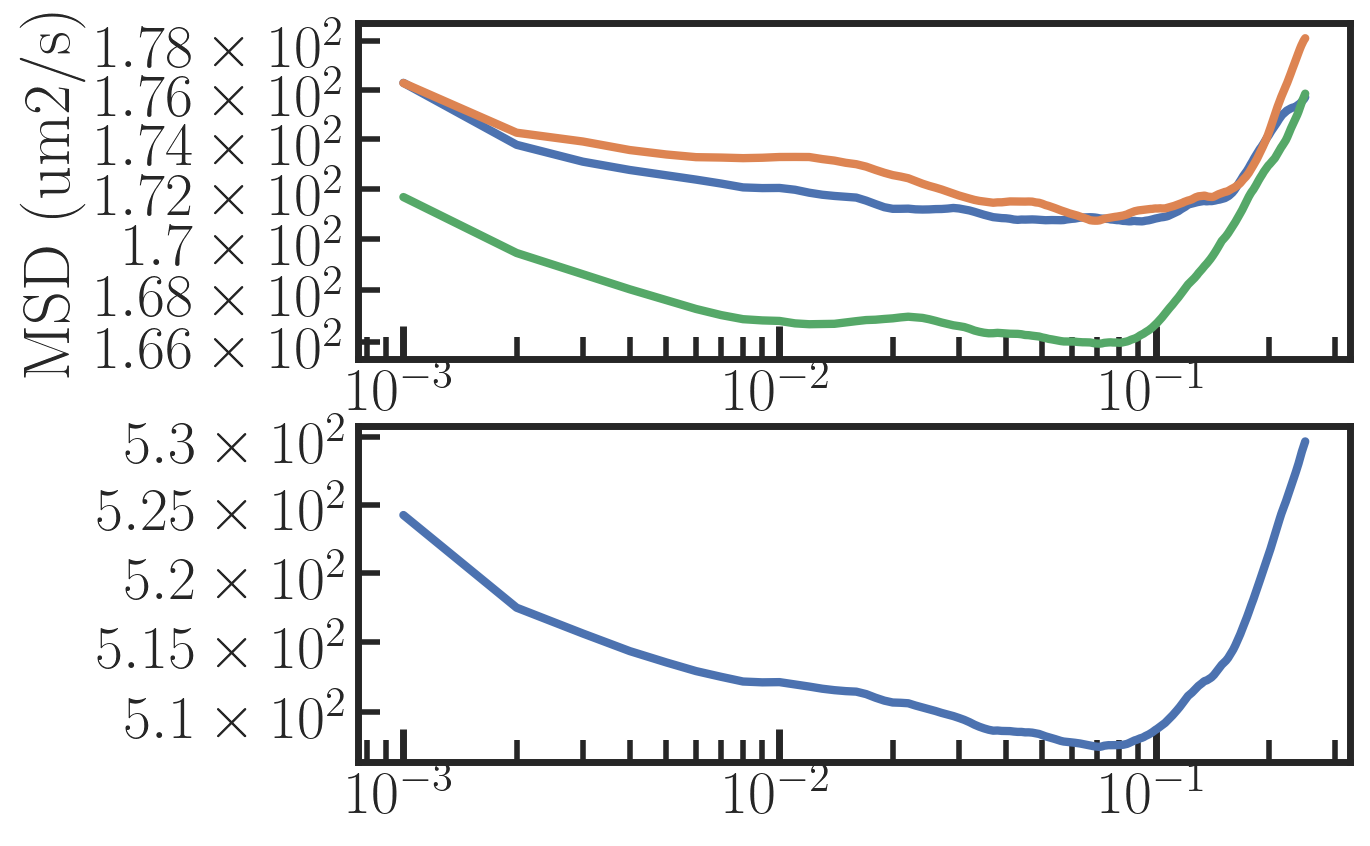

Processing /Users/juls/RigidMultiblobsWall-1/multi_bodies/examples/alex_problem/sweep_runs/phi=0.0005/all_runs.csv (phi=0.0005)


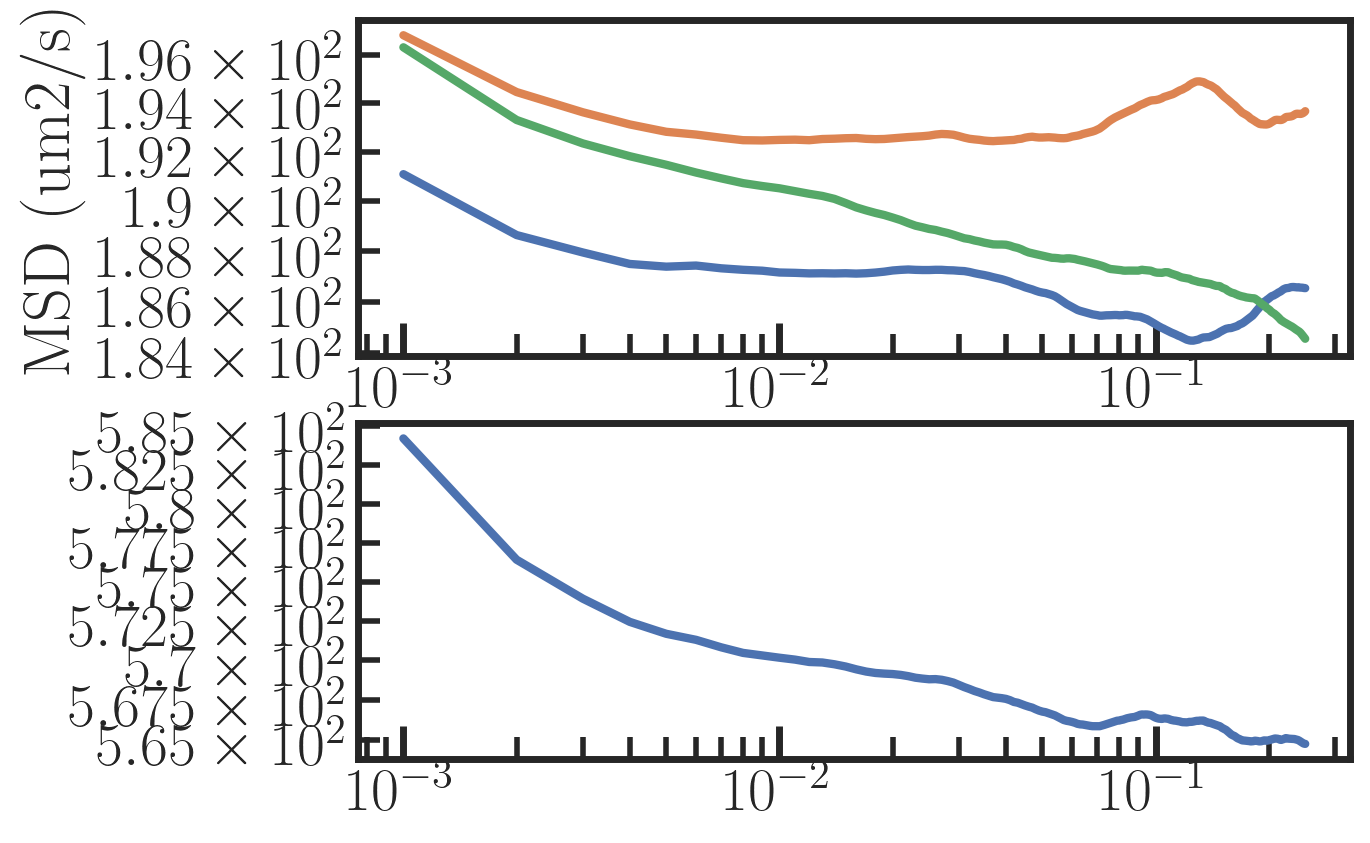

Processing /Users/juls/RigidMultiblobsWall-1/multi_bodies/examples/alex_problem/sweep_runs/phi=5e-05/all_runs.csv (phi=5e-05)


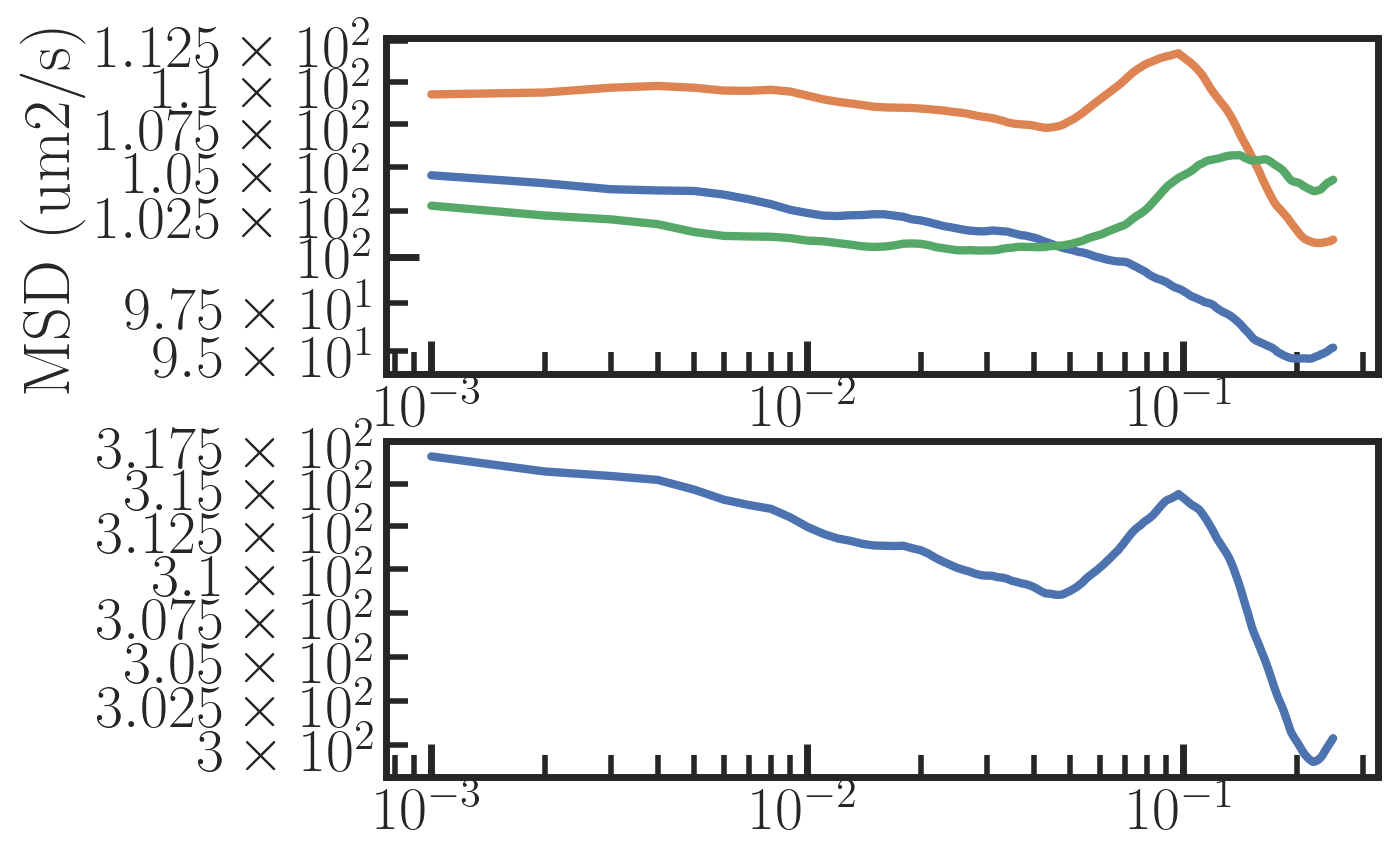

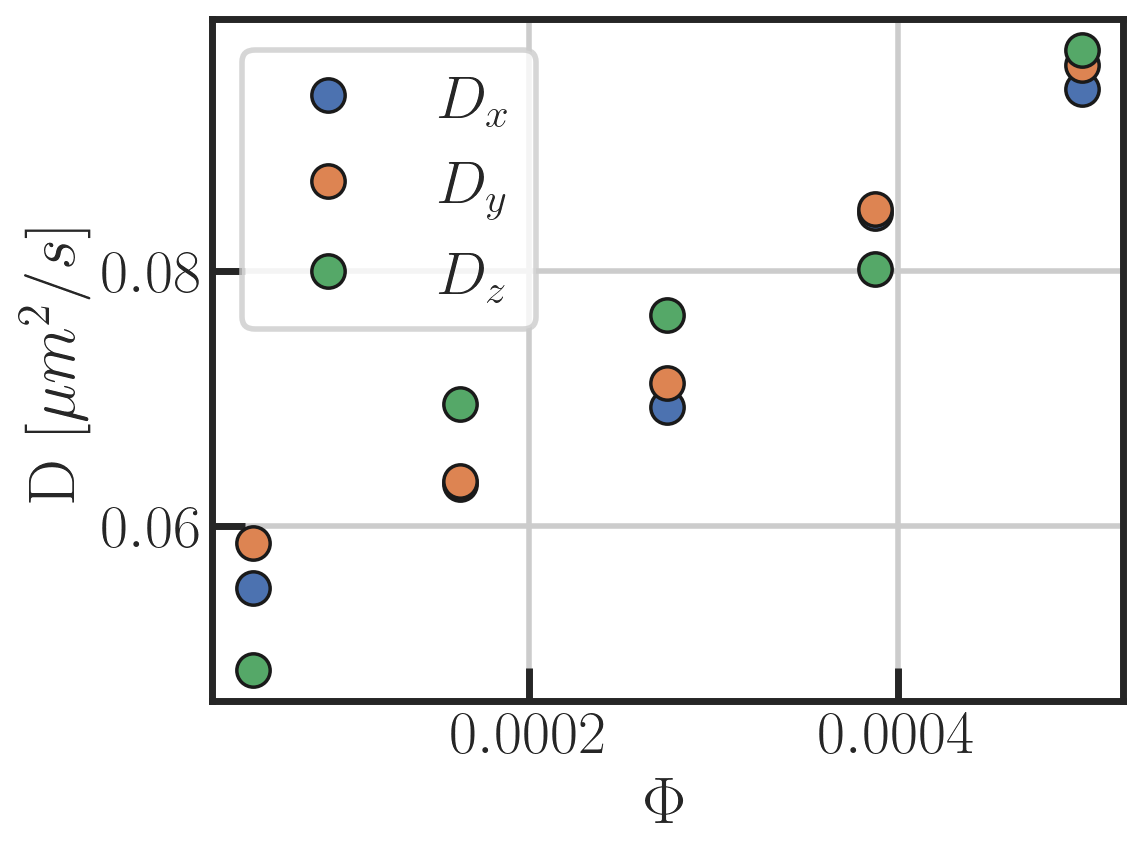

In [36]:
processing_all_csv(results_root=results_root, timestep_duration=timestep_duration, shear_rate=shear_rate)

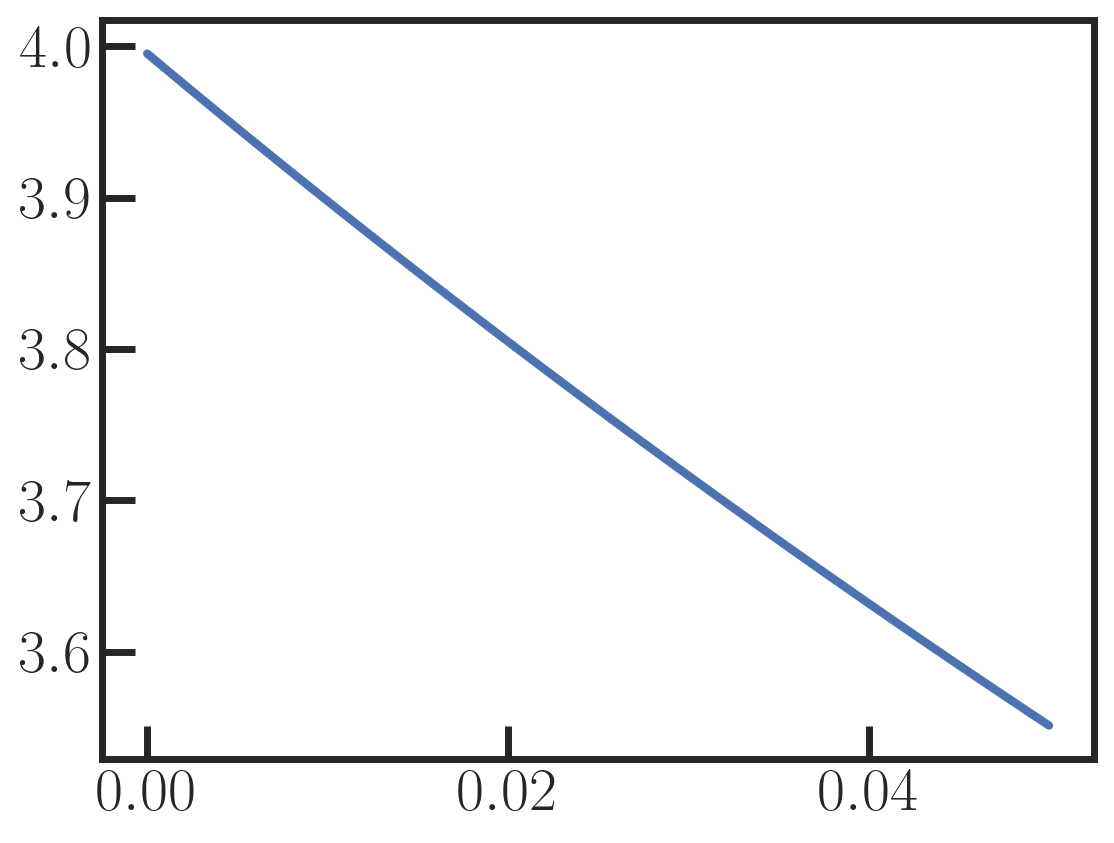

In [37]:
phitest = np.linspace(0, 5e-2)

eta = 1e-3 * ( 1 + 5/2 * phitest)

D = 0.0041419464 / (6 * np.pi * eta * 0.055)

plt.plot(phitest, D)
plt.show()